In [2]:
import json
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
import math
import scipy as sp
from scipy.stats import skew
from scipy.stats import kurtosis
import warnings
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib

pos_ret_raw =  pd.concat(map(pd.read_csv, ['./csvs02/returns_back/pos/' + file for file in os.listdir('./csvs02/returns_back/pos')])).sort_values(by=['t'])
neg_ret_raw =  pd.concat(map(pd.read_csv, ['./csvs02/returns_back/neg/' + file for file in os.listdir('./csvs02/returns_back/neg')])).sort_values(by=['t'])
ret_raw = pos_ret_raw.append(neg_ret_raw).sort_values(by=['t'])

def stats_all(data):
    mu = data.mean()
    stdev = data.std()
    skewn = skew(data)
    kurt = kurtosis(data)
    nobs = data.size
    print('Mean: ' + str(mu) + '\n')
    print('Std: ' + str(stdev) + '\n')
    print('Skewness: ' + str(skewn) + '\n')
    print('Kurtosis: ' + str(kurt) + '\n')
    print('Number of observations: ' + str(nobs) + '\n')
    return mu, stdev, skewn, kurt, nobs

/home/karolina/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Mean: -0.0032407670516661825

Std: 2.697166994023139

Skewness: 0.028195832412835676

Kurtosis: 1.011174182188637

Number of observations: 43803



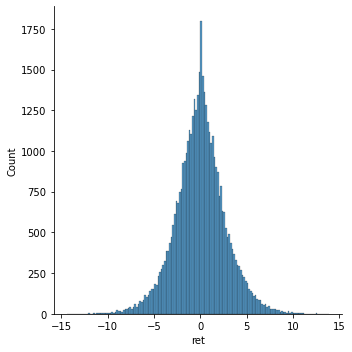

In [9]:
pos_log = np.log(pos_ret_raw['ret']/pos_ret_raw['ret'].shift(1)).dropna()
neg_log = np.log(neg_ret_raw['ret']/neg_ret_raw['ret'].shift(1)).dropna()
ret_log = np.log(ret_raw['ret']/ret_raw['ret'].shift(1)).dropna()
sns.displot(ret_log)
mu_cl, stdev_cl, skewn_cl, kurt_cl, nobs_cl = stats_all(ret_log)

In [29]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
   #Model data by finding best fit distribution to data
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                # try:
                    # if ax:
                        #NO PLOT
                        # pd.Series(pdf, x).plot(ax=ax)
                    # end
                # except Exception:
                    # pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    #Generate distributions's Probability Distribution Function

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

  1 / 101: ksone
  2 / 101: kstwo
  3 / 101: kstwobign
  4 / 101: norm
  5 / 101: alpha
  6 / 101: anglit
  7 / 101: arcsine
  8 / 101: beta
  9 / 101: betaprime
 10 / 101: bradford
 11 / 101: burr
 12 / 101: burr12
 13 / 101: fisk
 14 / 101: cauchy
 15 / 101: chi
 16 / 101: chi2
 17 / 101: cosine
 18 / 101: dgamma
 19 / 101: dweibull
 20 / 101: expon
 21 / 101: exponnorm
 22 / 101: exponweib
 23 / 101: exponpow
 24 / 101: fatiguelife
 25 / 101: foldcauchy
 26 / 101: f
 27 / 101: foldnorm
 28 / 101: weibull_min
 29 / 101: weibull_max
 30 / 101: frechet_r
 31 / 101: frechet_l
 32 / 101: genlogistic
 33 / 101: genpareto
 34 / 101: genexpon
 35 / 101: genextreme
 36 / 101: gamma
 37 / 101: erlang
 38 / 101: gengamma
 39 / 101: genhalflogistic
 40 / 101: gompertz
 41 / 101: gumbel_r
 42 / 101: gumbel_l
 43 / 101: halfcauchy
 44 / 101: halflogistic
 45 / 101: halfnorm
 46 / 101: hypsecant
 47 / 101: gausshyper
 48 / 101: invgamma
 49 / 101: invgauss
 50 / 101: geninvgauss
 51 / 101: norminv

Text(0, 0.5, 'Frequency')

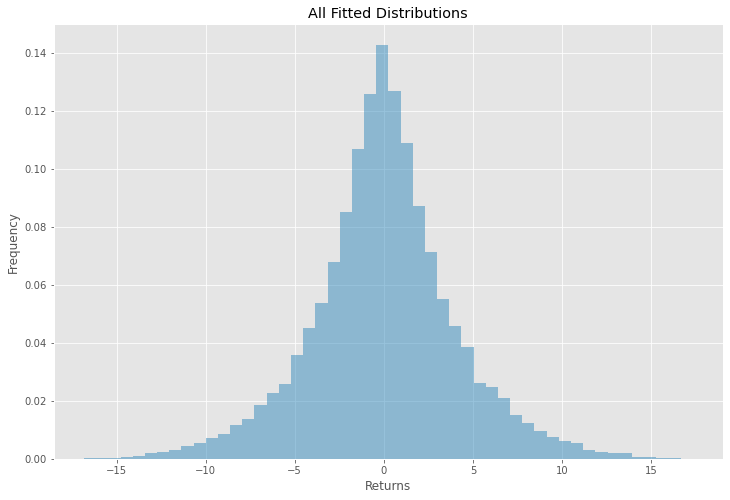

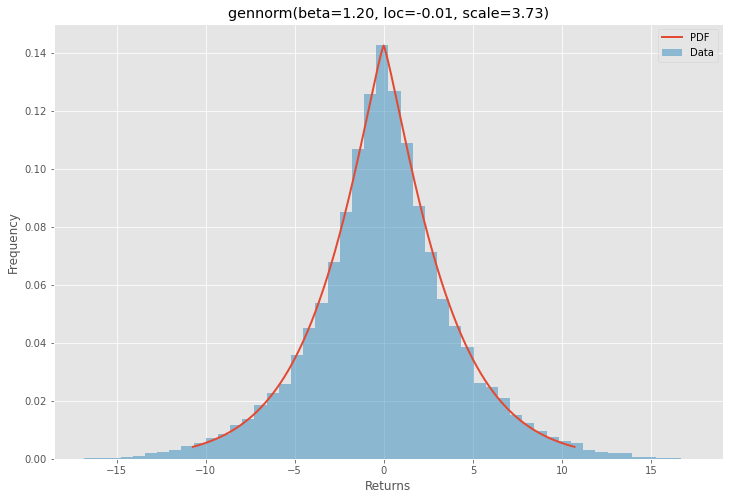

In [30]:
# Load data from statsmodels datasets
data = pd.Series(ret_log)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'All Fitted Distributions')
ax.set_xlabel(u'Returns')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(dist_str)
ax.set_xlabel('Returns')
ax.set_ylabel('Frequency')

### Heavy tails

Mean: -0.0018162910045296005

Std: 4.032256691769116

Skewness: 0.024087170742772553

Kurtosis: 1.0994702705460506

Number of observations: 41588

Mean: 425.8571841970621

Std: 16145.47093933979

Skewness: 4.440660256382595

Kurtosis: 374.91107010140144

Number of observations: 115298



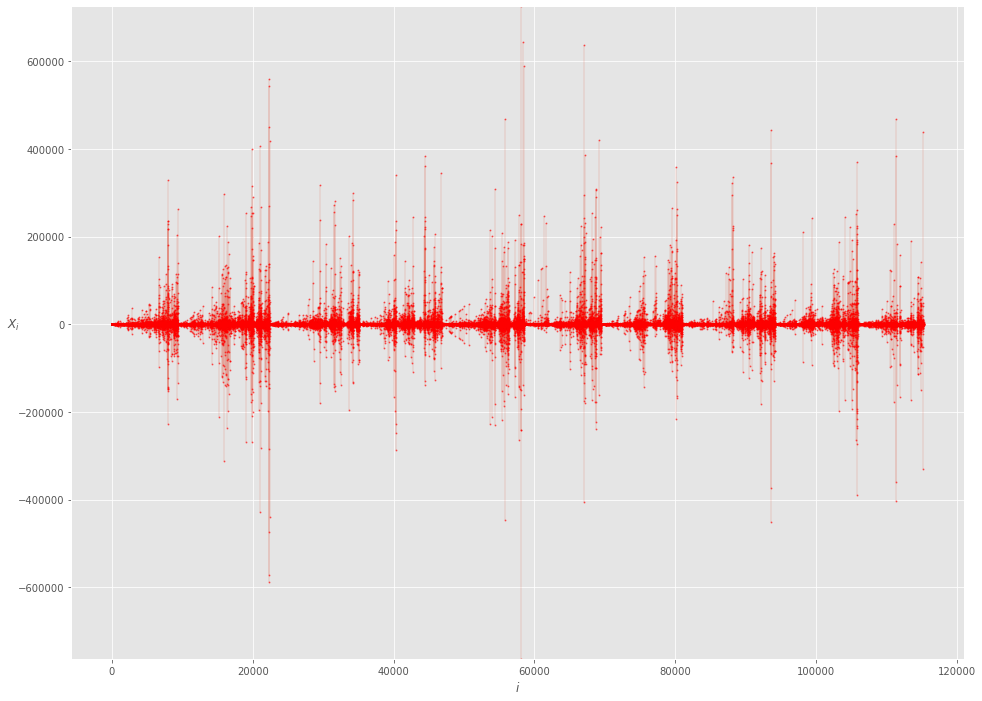

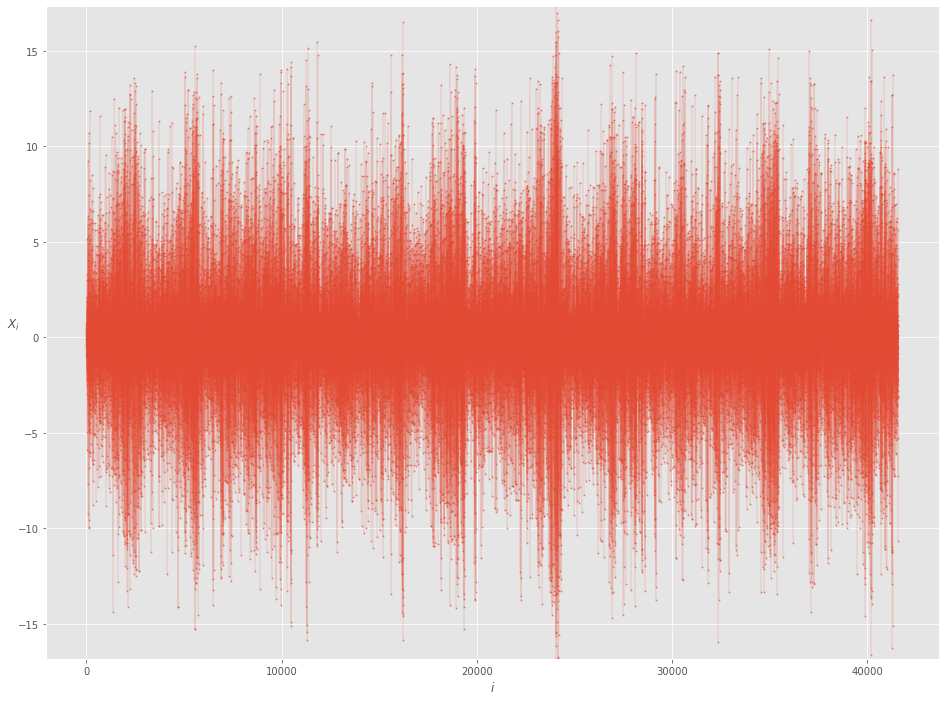

In [33]:
# to compare raw and log returns, not useful tbh
mu_cl, stdev_cl, skewn_cl, kurt_cl, nobs_cl = stats_all(ret_log)
n1 = nobs_cl
mu_cr, stdev_cr, skewn_cr, kurt_cr, nobs_cr = stats_all(ret_raw['ret'])
n2 = nobs_cr

fig, ax = plt.subplots()
data2 = ret_raw['ret']
ax.plot(list(range(n2)), data2, linestyle='', marker='o', alpha=0.5, ms=1, color='red')
ax.vlines(list(range(n2)), 0, data2, lw=0.2)
ax.set_ylim(min(data2), max(data2))
ax.set_xlabel('$i$')
ax.set_ylabel('$X_i$', rotation=0)
plt.show()

fig, ax = plt.subplots()
data1 = ret_log
ax.plot(list(range(n1)), data1, linestyle='', marker='o', alpha=0.5, ms=1)
ax.vlines(list(range(n1)), 0, data1, lw=0.2)
ax.set_ylim(min(data1), max(data1))
ax.set_xlabel('$i$')
ax.set_ylabel('$X_i$', rotation=0)
plt.show()


In [4]:
def hill_estimator(x, k):
    n = len(x)
    topk = np.sort(x)[-k:]
    hill = np.mean(np.log(topk)) - np.log(topk[-1])
    return hill


data = ret_log

# Calculate the Hill estimator with k=100
for perc in [0.01, 0.02, 0.03, 0.04, 0.05, 0.1]:
    k = int(data.size * perc)
    hill = hill_estimator(data, k)
    print("Hill estimator:", hill)


Hill estimator: -0.5341125746396007
Hill estimator: -0.656020451924092
Hill estimator: -0.739357404564899
Hill estimator: -0.8054698674786953
Hill estimator: -0.8609730516144654
Hill estimator: -1.0707262411931855


MLE instead of Hill:

In [5]:
from scipy.stats import genpareto
from scipy.optimize import minimize_scalar

data = ret_log

# Define the log-likelihood function for a generalized Pareto distribution
def log_likelihood(alpha, data):
    n = len(data)
    x = np.sort(data)
    x_min = np.min(x)
    log_likelihood = n * np.log(alpha) - n * np.log(x_min) - (alpha + 1) * np.sum(np.log(1 + (x - x_min) / (alpha * x_min)))
    return -log_likelihood

# Find the value of alpha that maximizes the log-likelihood
result = minimize_scalar(lambda alpha: -log_likelihood(alpha, data))#, bounds=(0, 100), method='bounded')
alpha_hat = result.x
print("Tail index estimate: ", alpha_hat)

<ipython-input-5-021afc0ea0e8>:11: RuntimeWarning: divide by zero encountered in log
  log_likelihood = n * np.log(alpha) - n * np.log(x_min) - (alpha + 1) * np.sum(np.log(1 + (x - x_min) / (alpha * x_min)))
<ipython-input-5-021afc0ea0e8>:11: RuntimeWarning: invalid value encountered in log
  log_likelihood = n * np.log(alpha) - n * np.log(x_min) - (alpha + 1) * np.sum(np.log(1 + (x - x_min) / (alpha * x_min)))
<ipython-input-5-021afc0ea0e8>:11: RuntimeWarning: divide by zero encountered in true_divide
  log_likelihood = n * np.log(alpha) - n * np.log(x_min) - (alpha + 1) * np.sum(np.log(1 + (x - x_min) / (alpha * x_min)))
<ipython-input-5-021afc0ea0e8>:11: RuntimeWarning: invalid value encountered in true_divide
  log_likelihood = n * np.log(alpha) - n * np.log(x_min) - (alpha + 1) * np.sum(np.log(1 + (x - x_min) / (alpha * x_min)))


Tail index estimate:  2.6180339603380443


### Gain/Loss Asymmetry

In [6]:
print(st.ks_2samp(pos_log, neg_log))

KstestResult(statistic=0.014973844737072417, pvalue=0.008022139115480357)


In [7]:
def ks_coeff(alpha):
    return math.sqrt(-1/2 * math.log(alpha/2))

for alpha in [0.01, 0.02, 0.03, 0.04, 0.05, 0.1]:
    n1, n2 = pos_log.size, neg_log.size
    critical_value = ks_coeff(alpha) * np.sqrt((n1 + n2) / (n1 * n2))
    print(str(alpha) + ': ' + str(critical_value))


0.01: 0.014685577186095877
0.02: 0.01369130603186261
0.03: 0.013074690962416641
0.04: 0.012618935946721314
0.05: 0.01225375710916383
0.1: 0.01104265578833828


Mean: 0.002509948837866979

Std: 2.6326945320368713

Skewness: 0.055102988892273136

Kurtosis: 1.2563848643779352

Number of observations: 18114

Mean: 7.624642643272704e-05

Std: 2.7549637417766664

Skewness: 0.03022571157199654

Kurtosis: 0.8797154724562226

Number of observations: 38163



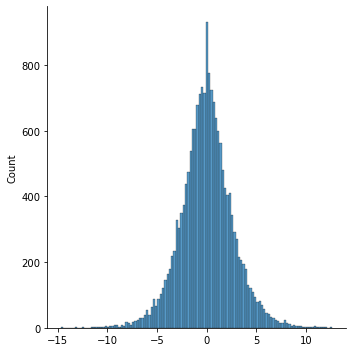

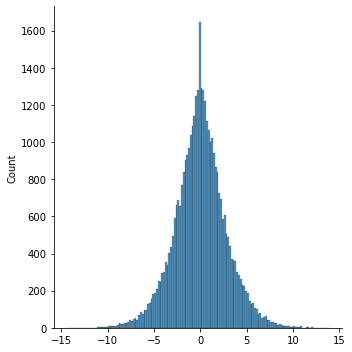

In [8]:
sns.displot(np.array(pos_log))
mu_clp, stdev_clp, skewn_clp, kurt_clp, nobs_clp = stats_all(np.array(pos_log))


sns.displot(np.array(neg_log))
mu_cln, stdev_cln, skewn_cln, kurt_cln, nobs_cln = stats_all(neg_log)

In [41]:
print(format(9.303093065969796e-06, 'f'))
print(format(-7.912317405946527e-06, 'f'))

0.000009
-0.000008


In [10]:

# Calculate the Hill estimator with k=100
for perc in [0.01, 0.02, 0.03, 0.04, 0.05, 0.1]:
    k = int(pos_log.size * perc)
    hill = hill_estimator(pos_log, k)
    print("Hill estimator:", hill)
print('\n')
for perc in [0.01, 0.02, 0.03, 0.04, 0.05, 0.1]:
    k = int(neg_log.size * perc)
    hill = hill_estimator(neg_log, k)
    print("Hill estimator:", hill)

Hill estimator: -0.42919127716074756
Hill estimator: -0.563022733923108
Hill estimator: -0.6525676418229194
Hill estimator: -0.722204338875041
Hill estimator: -0.7822313461691337
Hill estimator: -1.0028547265531038


Hill estimator: -0.5199979644610808
Hill estimator: -0.6432936231723505
Hill estimator: -0.7264793673720689
Hill estimator: -0.7922191225144506
Hill estimator: -0.8468293922809642
Hill estimator: -1.052307075173047


  1 / 101: ksone
  2 / 101: kstwo
  3 / 101: kstwobign
  4 / 101: norm
  5 / 101: alpha
  6 / 101: anglit
  7 / 101: arcsine
  8 / 101: beta
  9 / 101: betaprime
 10 / 101: bradford
 11 / 101: burr
 12 / 101: burr12
 13 / 101: fisk
 14 / 101: cauchy
 15 / 101: chi
 16 / 101: chi2
 17 / 101: cosine
 18 / 101: dgamma
 19 / 101: dweibull
 20 / 101: expon
 21 / 101: exponnorm
 22 / 101: exponweib
 23 / 101: exponpow
 24 / 101: fatiguelife
 25 / 101: foldcauchy
 26 / 101: f
 27 / 101: foldnorm
 28 / 101: weibull_min
 29 / 101: weibull_max
 30 / 101: frechet_r
 31 / 101: frechet_l
 32 / 101: genlogistic
 33 / 101: genpareto
 34 / 101: genexpon
 35 / 101: genextreme
 36 / 101: gamma
 37 / 101: erlang
 38 / 101: gengamma
 39 / 101: genhalflogistic
 40 / 101: gompertz
 41 / 101: gumbel_r
 42 / 101: gumbel_l
 43 / 101: halfcauchy
 44 / 101: halflogistic
 45 / 101: halfnorm
 46 / 101: hypsecant
 47 / 101: gausshyper
 48 / 101: invgamma
 49 / 101: invgauss
 50 / 101: geninvgauss
 51 / 101: norminv

Text(0, 0.5, 'Frequency')

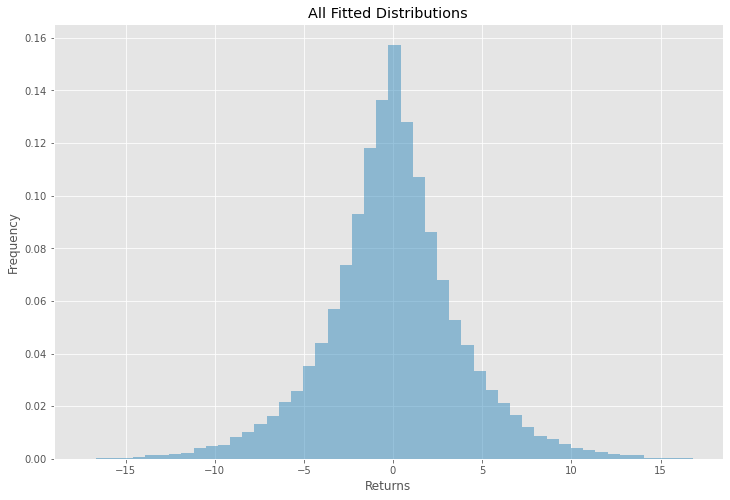

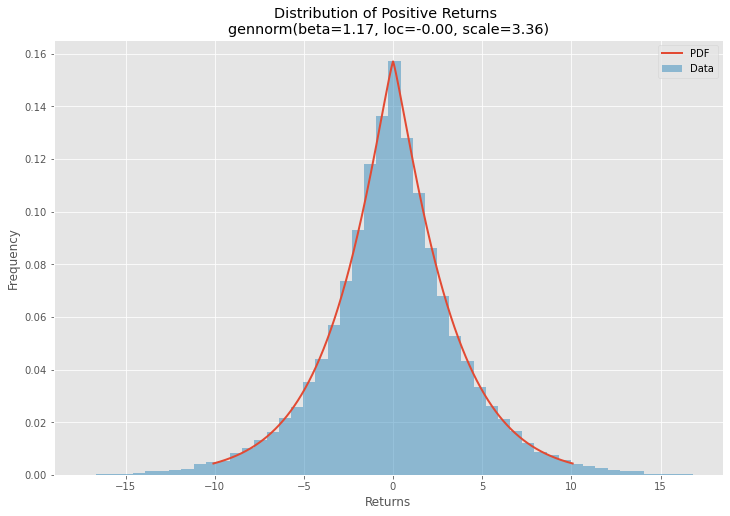

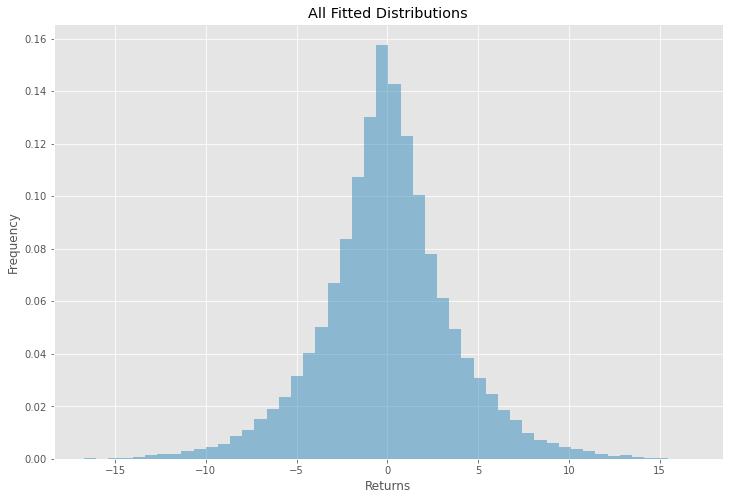

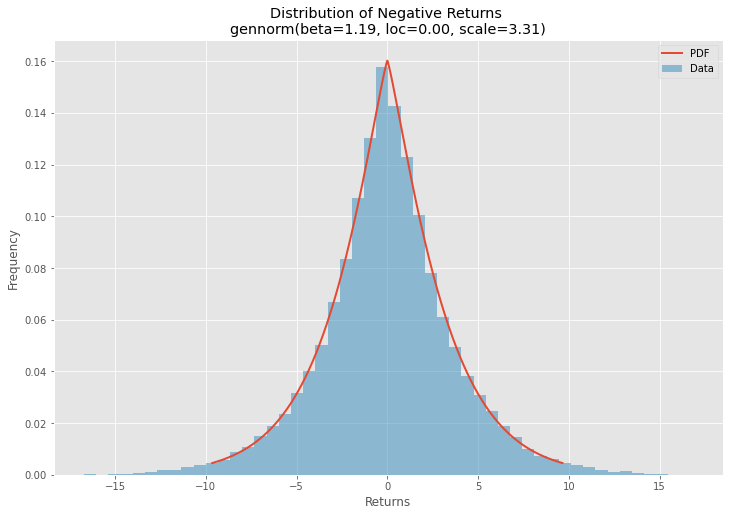

In [43]:
# Load data from statsmodels datasets
data = pd.Series(pos_log)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'All Fitted Distributions')
ax.set_xlabel(u'Returns')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'Distribution of Positive Returns \n' + dist_str)
ax.set_xlabel('Returns')
ax.set_ylabel('Frequency')


# Load data from statsmodels datasets
data = pd.Series(neg_log)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'All Fitted Distributions')
ax.set_xlabel(u'Returns')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'Distribution of Negative Returns \n' + dist_str)
ax.set_xlabel('Returns')
ax.set_ylabel('Frequency')